In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as snsF
import matplotlib.pyplot as plt

In [23]:
# Load static client attributes
static_client_df = pd.read_csv("datasets/static_client_data.csv")

# Load target labels (recommended strategy)
target_df = pd.read_csv("datasets/target_data.csv")

# Load time-series data (monthly records)
time_series_df = pd.read_csv("datasets/time_series_data.csv", parse_dates=["month"])

# Display first few rows of each dataset
print("Static Client Data:")
print(static_client_df.head())

print("\nTarget Data:")
print(target_df.head())

print("\nTime-Series Data:")
print(time_series_df.head())

Static Client Data:
                              client_id  age gender employment_status  \
0  96c4c0a3-bb3f-4ac1-81ad-0850cd29911f   63  Other          Salaried   
1  35fb4c11-fb1a-4eeb-addc-bd6ff6cb7934   43   Male          Salaried   
2  e5aafbe0-c869-41d9-acf1-1b019363e449   56  Other          Salaried   
3  43b978dd-4dd5-4f21-96d2-63ab16c814a3   37  Other           Retired   
4  abe77866-df1b-4a5c-ad96-eb78dff4ffc9   42   Male     Self-Employed   

   annual_income  debt_to_income_ratio  financial_knowledge_score  \
0       61244.14                  0.49                          5   
1      111338.35                  0.39                          1   
2       27581.32                  0.12                          5   
3       64813.50                  0.44                          4   
4      108668.65                  0.35                          2   

      investment_goals risk_appetite  investment_horizon_years  dependents  \
0           Retirement        Medium            

In [24]:
# Define aggregation functions
agg_funcs = {
    "portfolio_value": ["mean", "std", "last"],
    "equity_allocation_pct": ["mean", "std", "last"],
    "fixed_income_allocation_pct": ["mean", "std", "last"],
    "monthly_contribution": ["mean", "std", "sum"],
    "market_volatility_index": ["mean", "std", "last"],
    "macroeconomic_score": ["mean", "std", "last"],
    "sentiment_index": ["mean", "std", "last"]
}

# Aggregate per client
aggregated_df = time_series_df.groupby("client_id").agg(agg_funcs).reset_index()

# Flatten column names
aggregated_df.columns = ["_".join(col).strip() for col in aggregated_df.columns]

aggregated_df.rename(columns={"client_id_": "client_id"}, inplace=True)

In [25]:
def compute_trend(client_data):
    client_data = client_data.sort_values("month")  # Ensure chronological order
    x = range(len(client_data))  # 0 to 35 months
    y = client_data["portfolio_value"].values
    slope, _, _, _, _ = linregress(x, y)
    return slope

# Compute trend for each client
trend_df = time_series_df.groupby("client_id").apply(compute_trend).reset_index(name="trend_slope")

# Merge trend slope with aggregated data
aggregated_df = aggregated_df.merge(trend_df, on="client_id", how="left")

C:\Users\DELL\AppData\Local\Temp\ipykernel_10008\321797929.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_df = time_series_df.groupby("client_id").apply(compute_trend).reset_index(name="trend_slope")


In [26]:
# Merge with static client data
final_df = aggregated_df.merge(static_client_df, on="client_id", how="left")

# Merge with target labels
final_df = final_df.merge(target_df[["client_id", "recommended_strategy"]], on="client_id", how="left")

# Drop client_id (not needed for ML)
final_df = final_df.drop(columns=["client_id"])

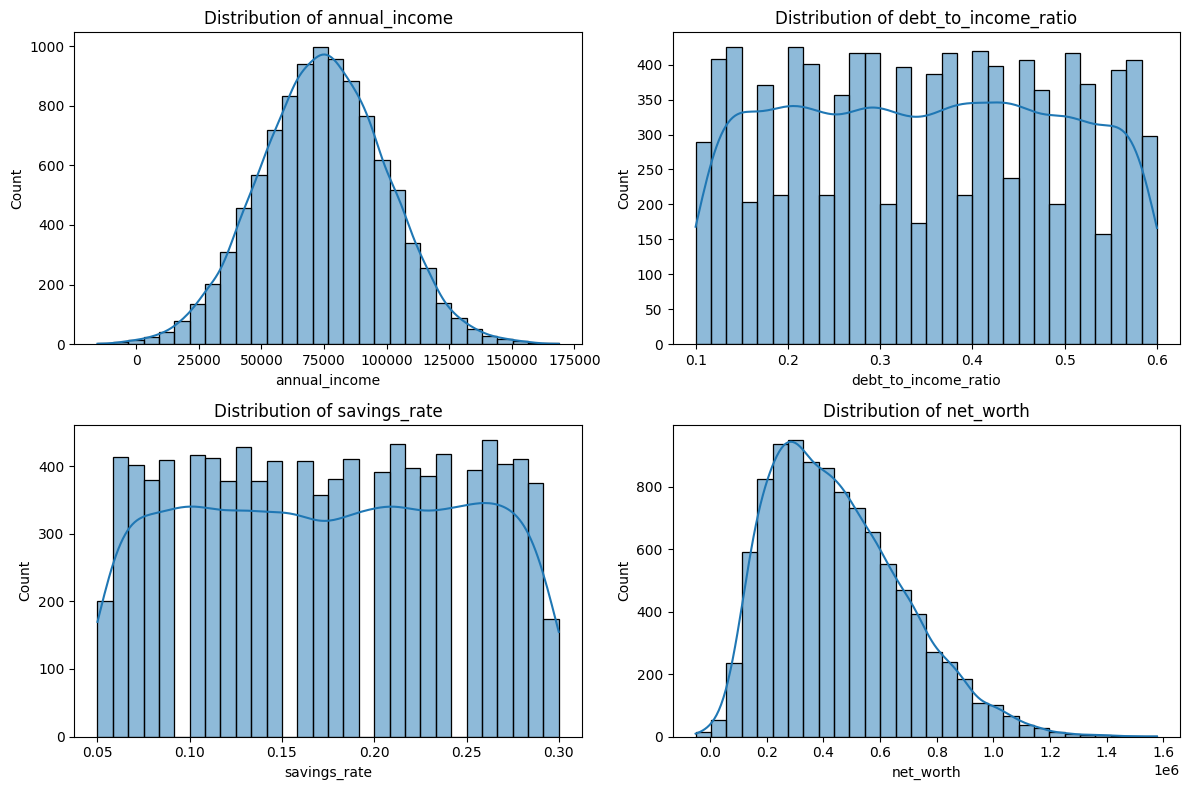

In [38]:
# Plot histograms of numerical features
num_cols = ["annual_income", "debt_to_income_ratio", "savings_rate", "net_worth"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(final_df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

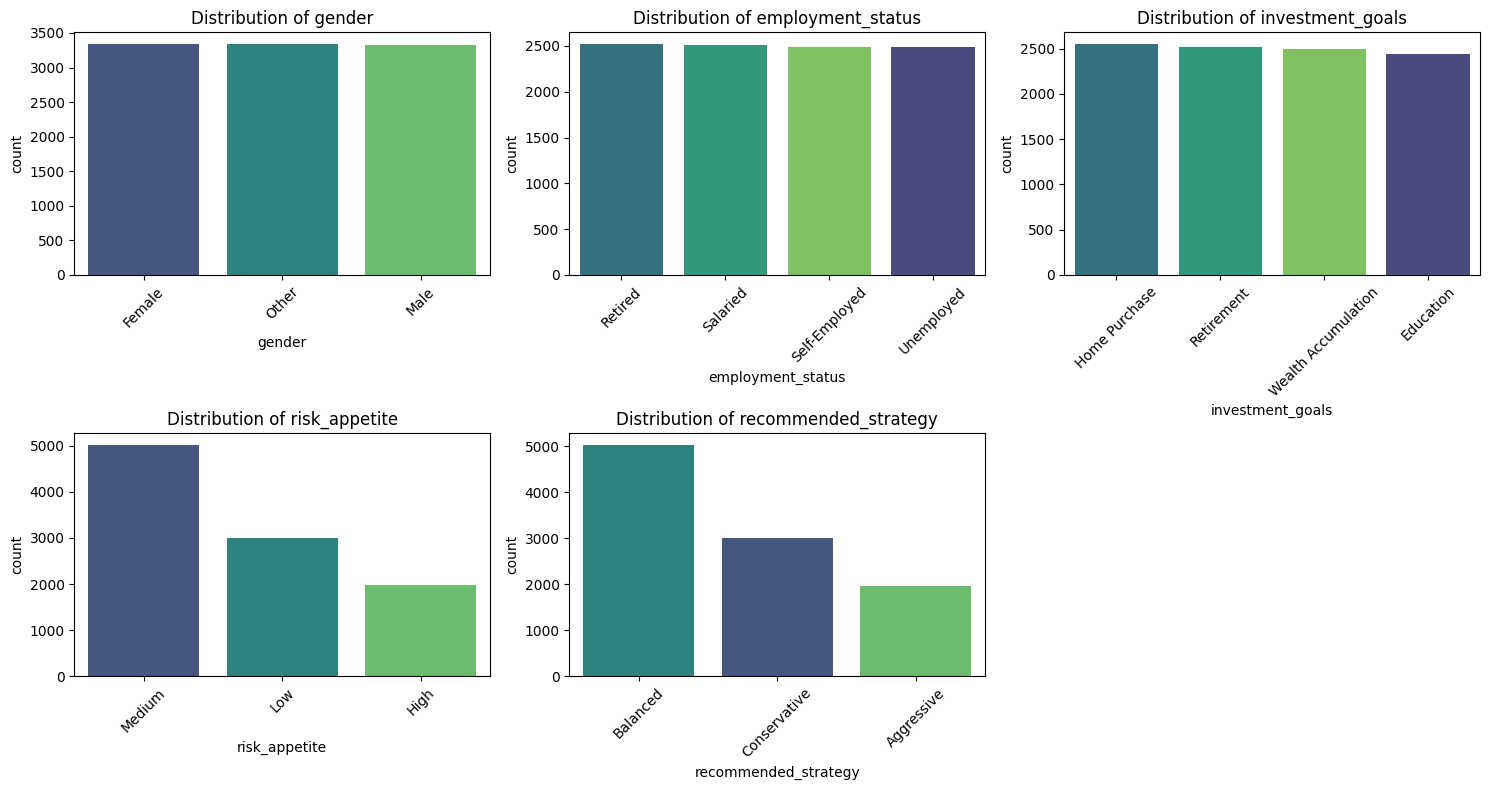

In [39]:
cat_cols = ["gender", "employment_status", "investment_goals", "risk_appetite", "recommended_strategy"]

plt.figure(figsize=(15, 8))

# Use a (2, 3) layout to accommodate all 5 plots
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)  # Change grid to (2, 3)
    sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, hue=col, palette="viridis", legend=False)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_10008\3852428965.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=final_df[col], palette="coolwarm")
C:\Users\DELL\AppData\Local\Temp\ipykernel_10008\3852428965.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=final_df[col], palette="coolwarm")
C:\Users\DELL\AppData\Local\Temp\ipykernel_10008\3852428965.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=final_df[col], palette="coolwarm")
C:\Users\DELL\AppData\Local\Temp\ipykernel_10008\3852428965.py:4: FutureWarning: 

Passing `palette`

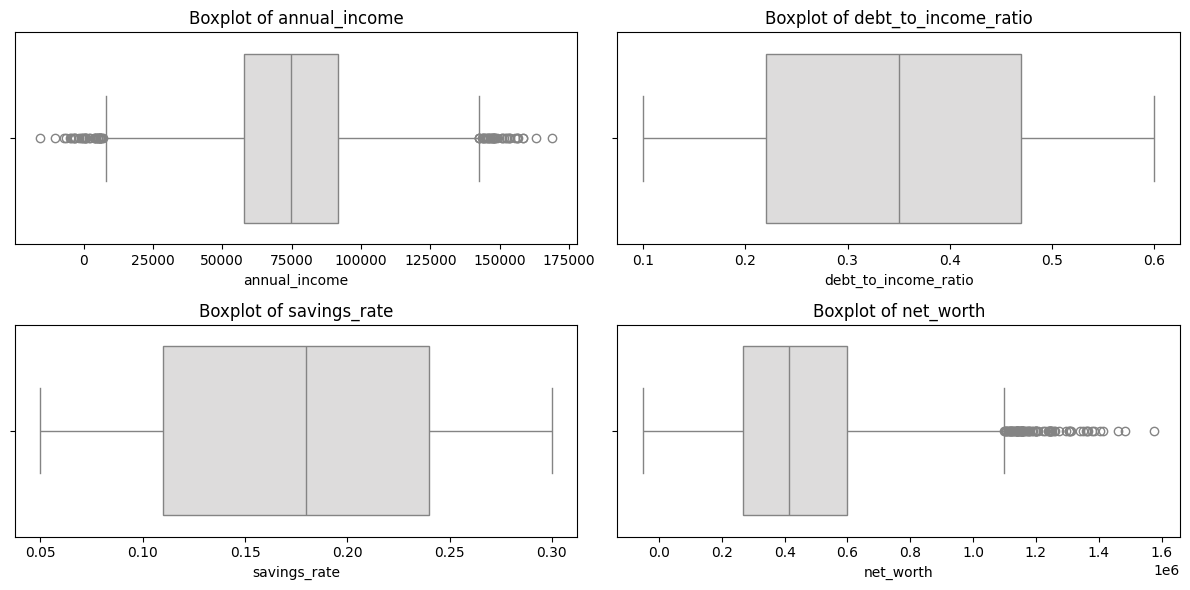

In [40]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=final_df[col], palette="coolwarm")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

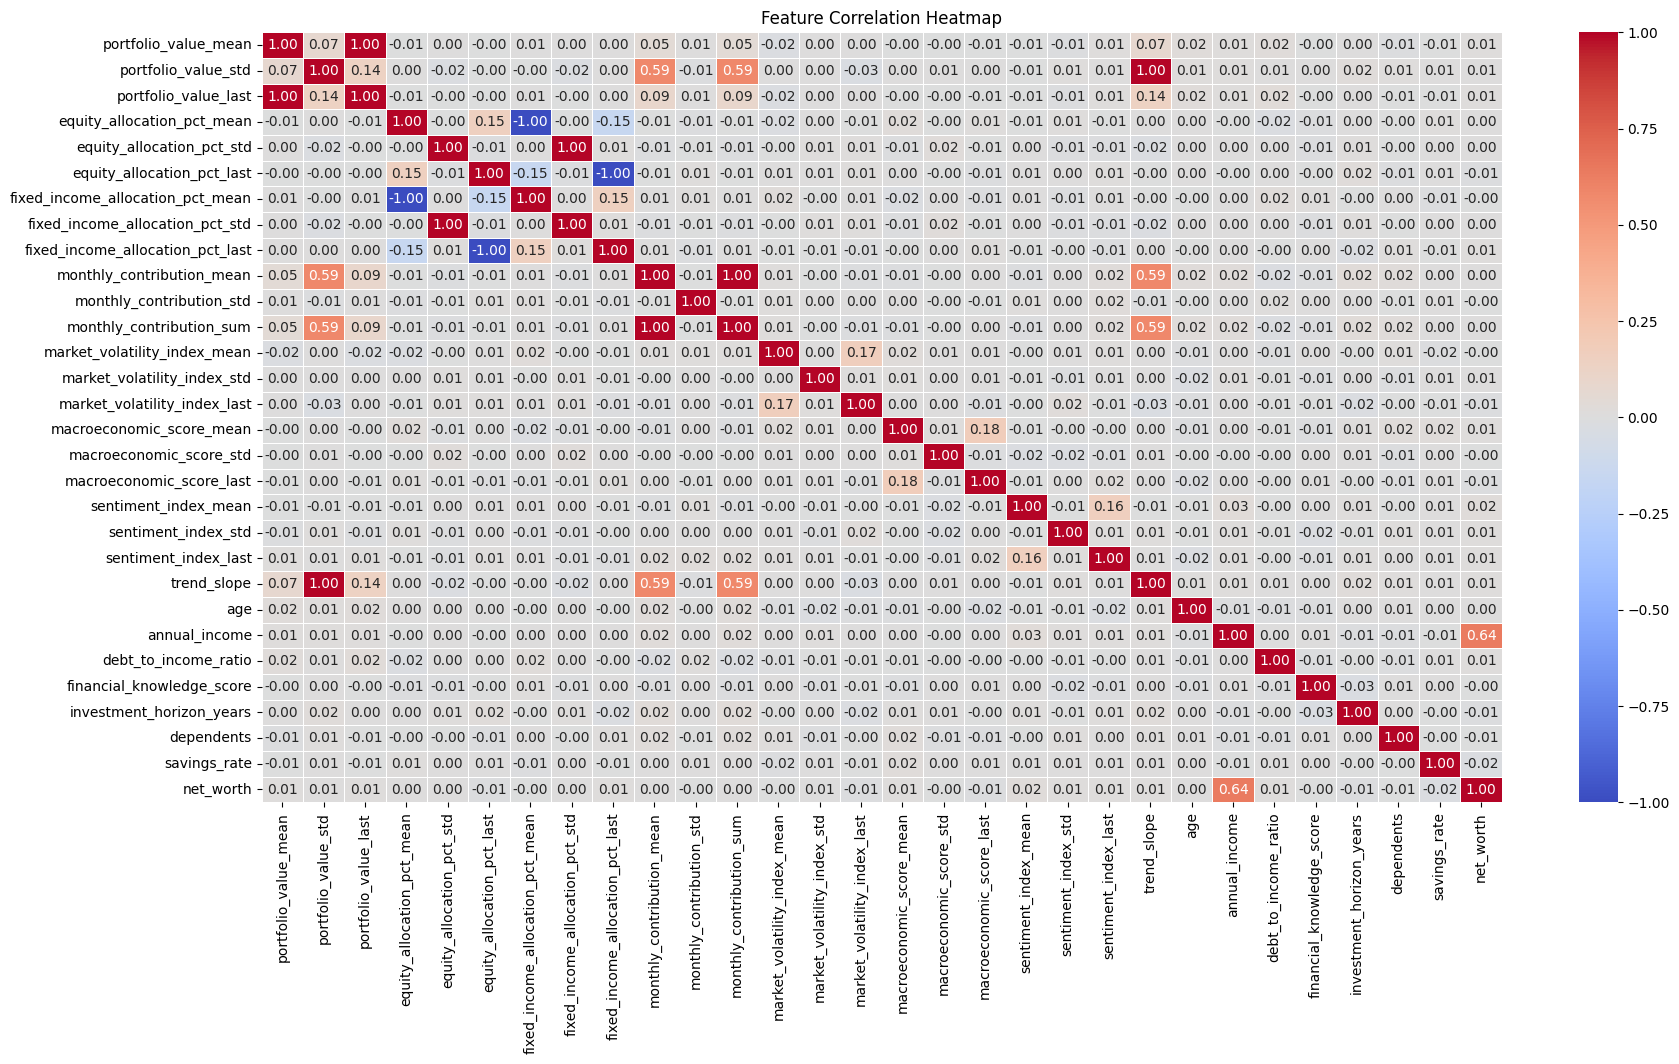

In [42]:
# Drop non-numeric columns (e.g., 'client_id', categorical variables already encoded)
numeric_data = final_df.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [49]:
# Income to Net Worth Ratio
final_df["income_to_networth_ratio"] = final_df["annual_income"] / (final_df["net_worth"] + 1e-6)

# Adjusted Debt to Income
final_df["adjusted_debt_to_income"] = final_df["debt_to_income_ratio"] * final_df["annual_income"]

# Investment Savings Ratio (Only if savings_rate is reliable)
final_df["investment_savings_ratio"] = final_df["portfolio_value_mean"] / (final_df["savings_rate"] + 1e-6)

# Age Groups
final_df["age_group"] = pd.cut(
    final_df["age"], bins=[18, 35, 55, np.inf], labels=["Young", "Mid-age", "Senior"], include_lowest=True
)

# Income Groups
final_df["income_group"] = pd.cut(
    final_df["annual_income"], bins=[0, 50000, 150000, np.inf], labels=["Low", "Medium", "High"], include_lowest=True
)

# Net Worth Levels
final_df["net_worth_level"] = pd.cut(
    final_df["net_worth"], bins=[0, 50000, 200000, np.inf], labels=["Poor", "Stable", "Wealthy"], include_lowest=True
)

# Total Financial Score
final_df["total_financial_score"] = (
    final_df["financial_knowledge_score"] + 
    final_df["macroeconomic_score_mean"] + 
    final_df["sentiment_index_mean"]
)

# Debt-to-Net Worth Ratio (New Feature)
final_df["debt_networth_ratio"] = (final_df["debt_to_income_ratio"] * final_df["annual_income"]) / (final_df["net_worth"] + 1e-6)

# Market Sensitivity Index (New Feature)
final_df["market_sensitivity"] = final_df["market_volatility_index_mean"] * final_df["equity_allocation_pct_mean"]

# Long-Term Portfolio Stability Score (New Feature)
final_df["portfolio_stability"] = final_df["portfolio_value_mean"] / (final_df["market_volatility_index_mean"] + 1e-6)

# Income vs. Portfolio Ratio (New Feature)
final_df["income_portfolio_ratio"] = final_df["annual_income"] / (final_df["portfolio_value_mean"] + 1e-6)

# Savings Rate Indicator (Binary: 1 if savings_rate > 20%, else 0)
final_df["high_savings"] = (final_df["savings_rate"] > 0.2).astype(int)

# Risk-adjusted Investment Horizon (Investment Horizon divided by risk level)
risk_map = {"Low": 1, "Medium": 2, "High": 3}
final_df["risk_adjusted_horizon"] = final_df["investment_horizon_years"] / final_df["risk_appetite"].replace(risk_map)

# Ensure numerical features have no negative values
final_df["annual_income"] = final_df["annual_income"].clip(lower=0)
final_df["net_worth"] = final_df["net_worth"].clip(lower=0)

C:\Users\DELL\AppData\Local\Temp\ipykernel_10008\252341386.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df["risk_adjusted_horizon"] = final_df["investment_horizon_years"] / final_df["risk_appetite"].replace(risk_map)


In [50]:
final_df.columns

Index(['portfolio_value_mean', 'portfolio_value_std', 'portfolio_value_last',
       'equity_allocation_pct_mean', 'equity_allocation_pct_std',
       'equity_allocation_pct_last', 'fixed_income_allocation_pct_mean',
       'fixed_income_allocation_pct_std', 'fixed_income_allocation_pct_last',
       'monthly_contribution_mean', 'monthly_contribution_std',
       'monthly_contribution_sum', 'market_volatility_index_mean',
       'market_volatility_index_std', 'market_volatility_index_last',
       'macroeconomic_score_mean', 'macroeconomic_score_std',
       'macroeconomic_score_last', 'sentiment_index_mean',
       'sentiment_index_std', 'sentiment_index_last', 'trend_slope', 'age',
       'gender', 'employment_status', 'annual_income', 'debt_to_income_ratio',
       'financial_knowledge_score', 'investment_goals', 'risk_appetite',
       'investment_horizon_years', 'dependents', 'preferred_asset_classes',
       'savings_rate', 'net_worth', 'recommended_strategy',
       'income_to_n

In [51]:
# Define the path where you want to save the file
save_path = "datasets/merge_classification.csv"

# Save the merged data as a CSV file
final_df.to_csv(save_path, index=False)

print(f"File saved successfully at: {save_path}")

File saved successfully at: datasets/merge_classification.csv


In [53]:
# Make a copy of the final dataset
df_processed = final_df.copy()

# 🔹 Step 1: Define Categorical Feature Groups
label_encode_cols = ["age_group", "income_group", "net_worth_level", "risk_appetite", "recommended_strategy"]  # Ordinal
one_hot_encode_cols = ["investment_goals", "employment_status", "gender"]  # Nominal
multi_label_cols = ["preferred_asset_classes"]  # Multi-label

In [54]:
# 🔹 Step 2: Label Encoding for Ordinal Categorical Features
encoders = {}  # Store encoders for future inverse transformation if needed
for col in label_encode_cols:
    encoder = LabelEncoder()
    df_processed[col + "_encoded"] = encoder.fit_transform(df_processed[col])
    df_processed.drop(columns=[col], inplace=True)  # Remove original column
    encoders[col] = encoder  # Store encoder for later use

In [55]:
# 🔹 Step 3: One-Hot Encoding for Nominal Categorical Features
df_processed = pd.get_dummies(df_processed, columns=one_hot_encode_cols)

In [56]:
# 🔹 Step 4: Multi-Label Binarization for Multi-Label Categorical Features
for col in multi_label_cols:
    df_processed[col] = df_processed[col].apply(eval)  # Convert string lists to real lists if stored as strings
    mlb = MultiLabelBinarizer()
    mlb_encoded = pd.DataFrame(mlb.fit_transform(df_processed[col]), columns=[col + "_" + c for c in mlb.classes_])
    
    df_processed = df_processed.join(mlb_encoded).drop(columns=[col])  # Drop original multi-label column

In [57]:
print(df_processed.columns)

Index(['portfolio_value_mean', 'portfolio_value_std', 'portfolio_value_last',
       'equity_allocation_pct_mean', 'equity_allocation_pct_std',
       'equity_allocation_pct_last', 'fixed_income_allocation_pct_mean',
       'fixed_income_allocation_pct_std', 'fixed_income_allocation_pct_last',
       'monthly_contribution_mean', 'monthly_contribution_std',
       'monthly_contribution_sum', 'market_volatility_index_mean',
       'market_volatility_index_std', 'market_volatility_index_last',
       'macroeconomic_score_mean', 'macroeconomic_score_std',
       'macroeconomic_score_last', 'sentiment_index_mean',
       'sentiment_index_std', 'sentiment_index_last', 'trend_slope', 'age',
       'annual_income', 'debt_to_income_ratio', 'financial_knowledge_score',
       'investment_horizon_years', 'dependents', 'savings_rate', 'net_worth',
       'income_to_networth_ratio', 'adjusted_debt_to_income',
       'investment_savings_ratio', 'total_financial_score',
       'debt_networth_ratio', 

In [58]:
scaler = RobustScaler()

y = df_processed["recommended_strategy_encoded"]  # Target variable
X = df_processed.drop(columns=["client_id", "recommended_strategy", "recommended_strategy_encoded"], errors="ignore")

# Step 6: Standard Scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [86]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import numpy as np

# Ensure reproducibility
np.random.seed(65)  # Set a fixed random seed

# Apply Mutual Information for feature selection
mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 10 features
X_selected = mi_selector.fit_transform(X_scaled_df, y)

# Get selected feature names
selected_features = X_scaled_df.columns[mi_selector.get_support()]
print("Selected Features using Mutual Information:", selected_features)

# Create final DataFrame with only selected features
X_final_df = pd.DataFrame(X_selected, columns=selected_features)

Selected Features using Mutual Information: Index(['equity_allocation_pct_mean', 'fixed_income_allocation_pct_mean',
       'monthly_contribution_mean', 'monthly_contribution_sum',
       'macroeconomic_score_last', 'annual_income', 'high_savings',
       'risk_adjusted_horizon', 'employment_status_Retired', 'gender_Male'],
      dtype='object')


In [122]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='saga'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

In [123]:
# Function to train and evaluate models
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        
        results[name] = acc
    return results

In [124]:
# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_final_df, y, test_size=0.2, random_state=42, stratify=y)

# Train and Evaluate Without Resampling
print("\nTraining Models Without Resampling")
baseline_results = evaluate_models(models, X_train, y_train, X_test, y_test)


Training Models Without Resampling

Training Logistic Regression...
Logistic Regression Accuracy: 0.5030
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       393
           1       0.50      1.00      0.67      1006
           2       0.00      0.00      0.00       601

    accuracy                           0.50      2000
   macro avg       0.17      0.33      0.22      2000
weighted avg       0.25      0.50      0.34      2000

Confusion Matrix:
 [[   0  393    0]
 [   0 1006    0]
 [   0  601    0]]

Training Random Forest...


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Random Forest Accuracy: 0.4670
Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.02      0.04       393
           1       0.50      0.85      0.63      1006
           2       0.30      0.12      0.17       601

    accuracy                           0.47      2000
   macro avg       0.32      0.33      0.28      2000
weighted avg       0.37      0.47      0.37      2000

Confusion Matrix:
 [[  8 352  33]
 [ 20 855 131]
 [ 27 503  71]]

Training XGBoost...


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:24:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.4460
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.08      0.12       393
           1       0.50      0.74      0.60      1006
           2       0.31      0.20      0.24       601

    accuracy                           0.45      2000
   macro avg       0.35      0.34      0.32      2000
weighted avg       0.39      0.45      0.40      2000

Confusion Matrix:
 [[ 31 296  66]
 [ 67 742 197]
 [ 36 446 119]]


In [91]:
# Train with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("\nTraining Models with SMOTE")
smote_results = evaluate_models(models, X_train_smote, y_train_smote, X_test, y_test)


Training Models with SMOTE

Training Logistic Regression...
Logistic Regression Accuracy: 0.2945
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.38      0.25       393
           1       0.51      0.20      0.28      1006
           2       0.30      0.41      0.34       601

    accuracy                           0.29      2000
   macro avg       0.33      0.33      0.29      2000
weighted avg       0.38      0.29      0.29      2000

Confusion Matrix:
 [[148  78 167]
 [395 197 414]
 [244 113 244]]

Training Random Forest...
Random Forest Accuracy: 0.3880
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.16      0.17       393
           1       0.50      0.55      0.52      1006
           2       0.30      0.27      0.28       601

    accuracy                           0.39      2000
   macro avg       0.33      0.33      0.32      2000
weighted avg       0.38 

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.3765
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.18      0.18       393
           1       0.49      0.50      0.50      1006
           2       0.29      0.29      0.29       601

    accuracy                           0.38      2000
   macro avg       0.32      0.32      0.32      2000
weighted avg       0.37      0.38      0.37      2000

Confusion Matrix:
 [[ 70 197 126]
 [201 508 297]
 [104 322 175]]


In [92]:
# Train with ADASYN
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
print("\nTraining Models with ADASYN")
adasyn_results = evaluate_models(models, X_train_adasyn, y_train_adasyn, X_test, y_test)


Training Models with ADASYN

Training Logistic Regression...
Logistic Regression Accuracy: 0.2655
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.41      0.26       393
           1       0.50      0.09      0.15      1006
           2       0.29      0.47      0.36       601

    accuracy                           0.27      2000
   macro avg       0.33      0.32      0.25      2000
weighted avg       0.38      0.27      0.23      2000

Confusion Matrix:
 [[160  39 194]
 [431  86 489]
 [269  47 285]]

Training Random Forest...
Random Forest Accuracy: 0.3835
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.22      0.21       393
           1       0.50      0.49      0.49      1006
           2       0.32      0.31      0.32       601

    accuracy                           0.38      2000
   macro avg       0.34      0.34      0.34      2000
weighted avg       0.39

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:20:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.3770
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.20      0.20       393
           1       0.49      0.48      0.49      1006
           2       0.30      0.31      0.31       601

    accuracy                           0.38      2000
   macro avg       0.33      0.33      0.33      2000
weighted avg       0.38      0.38      0.38      2000

Confusion Matrix:
 [[ 79 200 114]
 [203 487 316]
 [112 301 188]]


In [93]:
# Voting Classifier (Ensemble of Best Models)
print("\nTraining Voting Classifier")
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"))
], voting='soft')

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, y_pred_voting)

print(f"\nVoting Classifier Accuracy: {voting_acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_voting))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_voting))


Training Voting Classifier


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:21:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Voting Classifier Accuracy: 0.4635
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.04      0.07       393
           1       0.50      0.83      0.63      1006
           2       0.28      0.13      0.18       601

    accuracy                           0.46      2000
   macro avg       0.34      0.33      0.29      2000
weighted avg       0.39      0.46      0.38      2000

Confusion Matrix:
 [[ 16 326  51]
 [ 26 833 147]
 [ 23 500  78]]


In [116]:
# Define Class Weights (since class "Balanced" is overrepresented)
class_weights = {0: 2.5, 1: 1.0, 2: 2.0}

# Initialize Models with Class Weights
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight=class_weights,max_iter=1000, solver='saga'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")  # XGBoost handles imbalance well
}

In [117]:
# Train and Evaluate Each Model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)  # Train on Resampled Data
    
    y_pred = model.predict(X_test)
    
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Training Random Forest...
Random Forest Accuracy: 0.4795
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.02      0.03       393
           1       0.50      0.88      0.64      1006
           2       0.32      0.11      0.16       601

    accuracy                           0.48      2000
   macro avg       0.33      0.34      0.28      2000
weighted avg       0.38      0.48      0.38      2000

Confusion Matrix:
 [[  6 350  37]
 [ 14 887 105]
 [ 14 521  66]]

Training Logistic Regression...
Logistic Regression Accuracy: 0.2990
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       393
           1       0.23      0.00      0.01      1006
           2       0.30      0.99      0.46       601

    accuracy                           0.30      2000
   macro avg       0.18      0.33      0.16      2000
weighted avg       0.21      0.30      0.14      200

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

XGBoost Accuracy: 0.4460
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.08      0.12       393
           1       0.50      0.74      0.60      1006
           2       0.31      0.20      0.24       601

    accuracy                           0.45      2000
   macro avg       0.35      0.34      0.32      2000
weighted avg       0.39      0.45      0.40      2000

Confusion Matrix:
 [[ 31 296  66]
 [ 67 742 197]
 [ 36 446 119]]


In [97]:
from imblearn.combine import SMOTEENN

# Resampling using SMOTEENN (Better than SMOTE/ADASYN)
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

In [98]:
# Train and Evaluate Each Model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_resampled, y_train_resampled)  # Train on Resampled Data
    
    y_pred = model.predict(X_test)
    
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Training Random Forest...
Random Forest Accuracy: 0.2430
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.64      0.30       393
           1       0.55      0.03      0.05      1006
           2       0.30      0.34      0.32       601

    accuracy                           0.24      2000
   macro avg       0.35      0.34      0.23      2000
weighted avg       0.41      0.24      0.18      2000

Confusion Matrix:
 [[251   7 135]
 [638  29 339]
 [378  17 206]]

Training Logistic Regression...
Logistic Regression Accuracy: 0.1970
Classification Report:
               precision    recall  f1-score   support

           0       0.20      1.00      0.33       393
           1       0.00      0.00      0.00      1006
           2       0.20      0.00      0.00       601

    accuracy                           0.20      2000
   macro avg       0.13      0.33      0.11      2000
weighted avg       0.10      0.20      0.07      200

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

XGBoost Accuracy: 0.2460
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.50      0.26       393
           1       0.50      0.10      0.17      1006
           2       0.28      0.32      0.30       601

    accuracy                           0.25      2000
   macro avg       0.32      0.31      0.24      2000
weighted avg       0.37      0.25      0.23      2000

Confusion Matrix:
 [[195  39 159]
 [565 104 337]
 [342  66 193]]


In [102]:
# 📌 Hyperparameter Tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight=class_weights, random_state=42), 
                              rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)
print("\nBest Random Forest Parameters:", grid_search_rf.best_params_)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [103]:
# 📌 Train Final Random Forest Model with Best Hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    min_samples_split=2, 
    class_weight=class_weights, 
    random_state=42
)

# Train the model
best_rf.fit(X_train, y_train)

# Predictions on Test Set
y_pred_rf = best_rf.predict(X_test)

# 📌 Evaluate Model Performance
print("Final Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Final Random Forest Accuracy: 0.4785

Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.01      0.01       393
           1       0.50      0.89      0.64      1006
           2       0.31      0.09      0.14       601

    accuracy                           0.48      2000
   macro avg       0.31      0.33      0.27      2000
weighted avg       0.37      0.48      0.37      2000


Confusion Matrix:
 [[  3 364  26]
 [ 13 899  94]
 [ 14 532  55]]


In [104]:
# 📌 Hyperparameter Tuning for XGBoost
xgb_param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"), 
                               xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)
print("\nBest XGBoost Parameters:", grid_search_xgb.best_params_)

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:38:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [110]:
best_xgb = XGBClassifier(
    learning_rate=0.01, 
    max_depth=3, 
    n_estimators=200, 
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    random_state=42
)

# Train the model
best_xgb.fit(X_train, y_train)

# Predictions on Test Set
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate Model Performance
print("Final XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:43:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final XGBoost Accuracy: 0.5035

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       393
           1       0.50      1.00      0.67      1006
           2       0.33      0.00      0.00       601

    accuracy                           0.50      2000
   macro avg       0.28      0.33      0.22      2000
weighted avg       0.35      0.50      0.34      2000


Confusion Matrix:
 [[   0  391    2]
 [   0 1006    0]
 [   0  600    1]]


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [118]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
lr_model = LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced')

# Create Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('lr', lr_model)],
    voting='soft'  # 'hard' for majority voting, 'soft' for probability averaging
)

# Train and evaluate
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy:.4f}")


Ensemble Accuracy: 0.4805
